In [1]:

import numpy as np
import pandas as pd
from math import lgamma, log
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from pathlib import Path

sns.set_theme(style="whitegrid", rc={"figure.dpi": 120})


# Auto-root (specifying path)
ROOT = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd().resolve()
DATA_DIR   = ROOT / "data"
POINTS_DIR = ROOT / "points"

training_csvs = [DATA_DIR / "E0_19_20.csv", DATA_DIR / "E0_20_21.csv", DATA_DIR / "E0_21_22.csv"]
backtest_fixtures_csvs   = [DATA_DIR / "epl_22_23_fixtures.csv", DATA_DIR / "epl_23_24_fixtures.csv"]
backtest_actual_pts_csvs = [POINTS_DIR / "epl_2022_23_points.csv", POINTS_DIR / "epl_2023_24_points.csv"]
future_fixtures_csvs     = [DATA_DIR / "epl_24_25_fixtures.csv", DATA_DIR / "epl_25_26_fixtures.csv"]

# Monte Carlo simulations per season
N_SIMS = 500


# 1) Data Loading & Engineering
def load_and_engineer_data(path: str) -> pd.DataFrame:
    cols = ["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]
    df = pd.read_csv(path, usecols=cols, dayfirst=True, parse_dates=["Date"])

    # Basic NA handling
    df = df.dropna(how="any", subset=["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"])
    
    # Strip extra spaces from team names
    df["HomeTeam"] = df["HomeTeam"].str.strip()
    df["AwayTeam"] = df["AwayTeam"].str.strip()

    # Ensure goals are integers and non-negative
    df["FTHG"] = pd.to_numeric(df["FTHG"], errors="coerce").fillna(0).astype(int)
    df["FTAG"] = pd.to_numeric(df["FTAG"], errors="coerce").fillna(0).astype(int)
    df = df[(df["FTHG"] >= 0) & (df["FTAG"] >= 0)]

    # Sort by date
    df = df.sort_values("Date").reset_index(drop=True)

    # EDA: Print missing values summary
    missing_summary = df.isnull().sum()
    if missing_summary.any():
        print(f"[WARNING] Missing values found in {path.name}:")
        print(missing_summary[missing_summary > 0])
    else:
        print(f"[INFORMATION] No missing values in {path.name}")

    return df

def get_unique_teams(df: pd.DataFrame):
    return sorted(pd.unique(pd.concat([df["HomeTeam"], df["AwayTeam"]])))


In [ ]:

# 2) Elo Ratings with Decay

def compute_elo(df: pd.DataFrame, teams, K: float = 30.0, decay: float = 1.0):
    """
    Compute Elo with decay. Effective step = (1 - decay) * K.
    Returns (df_with_elos, final_elo_dict).
    """
    elo = {t: 1500.0 for t in teams}
    out = df.copy()
    out["HomeElo"] = np.nan
    out["AwayElo"] = np.nan

    for i, r in out.iterrows():
        h, a = r["HomeTeam"], r["AwayTeam"]
        Rh, Ra = elo[h], elo[a]
        out.at[i, "HomeElo"] = Rh
        out.at[i, "AwayElo"] = Ra

        Eh = 1.0 / (1.0 + 10.0 ** ((Ra - Rh) / 400.0))
        Ea = 1.0 - Eh

        if r["FTHG"] > r["FTAG"]:
            Sh = 1.0
        elif r["FTHG"] < r["FTAG"]:
            Sh = 0.0
        else:
            Sh = 0.5
        Sa = 1.0 - Sh

        # Simplified & correct with decay factor
        elo[h] = Rh + (1.0 - decay) * K * (Sh - Eh)
        elo[a] = Ra + (1.0 - decay) * K * (Sa - Ea)

    return out, elo


In [3]:

# 3) Bivariate Poisson pmf & Likelihood
def _log_dpois(k: int, lam: float) -> float:
    if lam <= 0:
        return -np.inf if k > 0 else 0.0
    return k * log(lam) - lam - lgamma(k + 1.0)

def _logsumexp(a: np.ndarray) -> float:
    m = np.max(a)
    return m + np.log(np.sum(np.exp(a - m)))

def log_bipois(x: int, y: int, lam1: float, lam2: float, lam3: float) -> float:
    kmax = min(x, y)
    logs = []
    for k in range(kmax + 1):
        logs.append(_log_dpois(x - k, lam1) + _log_dpois(y - k, lam2) + _log_dpois(k, lam3))
    return _logsumexp(np.array(logs))

def bipois_nll(par: np.ndarray, df_e: pd.DataFrame, teams, gamma: float, lambda_ridge: float) -> float:
    """Negative penalized log-likelihood."""
    n = len(teams)
    atk  = par[0:n].copy()
    dfn  = par[n:2*n].copy()
    hAdv = par[2*n:3*n].copy()
    lam3 = np.exp(par[3*n])
    idx = {t: i for i, t in enumerate(teams)}

    ll = -lambda_ridge * (np.sum(atk**2) + np.sum(dfn**2))
    for _, r in df_e.iterrows():
        iH = idx[r["HomeTeam"]]; iA = idx[r["AwayTeam"]]
        ratio = (r["HomeElo"] / r["AwayElo"]) if r["AwayElo"] > 0 else 1.0
        lam1 = np.exp(atk[iH] - dfn[iA] + hAdv[iH]) * (ratio ** gamma)
        lam2 = np.exp(atk[iA] - dfn[iH]) / (ratio ** gamma)
        ll += log_bipois(int(r["FTHG"]), int(r["FTAG"]), float(lam1), float(lam2), float(lam3))
    return -ll  # minimize

def fit_bipois(df_e: pd.DataFrame, teams, gamma: float = 0.1, lambda_ridge: float = 0.01):
    """BFGS fit with zero-mean constraints on attack & defence."""
    n = len(teams)
    init = np.zeros(3*n + 1, dtype=float)
    init[3*n] = np.log(0.1)  # initial shared component

    def obj(p):
        p = p.copy()
        p[0:n]   -= np.mean(p[0:n])
        p[n:2*n] -= np.mean(p[n:2*n])
        return bipois_nll(p, df_e, teams, gamma, lambda_ridge)

    res = minimize(obj, init, method="BFGS", options={"maxiter": 400, "gtol": 1e-5})
    p = res.x.copy()
    p[0:n]   -= np.mean(p[0:n])
    p[n:2*n] -= np.mean(p[n:2*n])
    idx = {t: i for i, t in enumerate(teams)}
    return {"par": p, "idx": idx}


In [4]:

# 4) Simulations
_rng = np.random.default_rng(1)

def simulate_match(h: str, a: str, par: np.ndarray, idx: dict, elo: dict, gamma: float):
    n = len(idx)
    i = idx[h]; j = idx[a]
    atk  = par[0:n]; dfn  = par[n:2*n]; hAdv = par[2*n:3*n]; lam3 = np.exp(par[3*n])

    ratio = (elo[h] / elo[a]) if elo[a] > 0 else 1.0
    lam1 = np.exp(atk[i] - dfn[j] + hAdv[i]) * (ratio ** gamma)
    lam2 = np.exp(atk[j] - dfn[i]) / (ratio ** gamma)

    k = _rng.poisson(lam3)
    x = _rng.poisson(lam1)
    y = _rng.poisson(lam2)
    return x + k, y + k

def simulate_season(fixtures: pd.DataFrame, par: np.ndarray, idx: dict, elo: dict, gamma: float):
    pts = {team: 0 for team in idx.keys()}
    for _, r in fixtures.iterrows():
        h, a = r["HomeTeam"], r["AwayTeam"]
        x, y = simulate_match(h, a, par, idx, elo, gamma)
        if x > y:
            pts[h] += 3
        elif x < y:
            pts[a] += 3
        else:
            pts[h] += 1; pts[a] += 1
    return pts

def monte_carlo(fixtures: pd.DataFrame, par: np.ndarray, idx: dict, elo: dict, gamma: float, n: int = 100):
    teams = list(idx.keys())
    sims = []
    for _ in range(n):
        pts = simulate_season(fixtures, par, idx, elo, gamma)
        sims.append([pts[t] for t in teams])
    mat = np.array(sims).T  # teams x n
    return pd.DataFrame(mat, index=teams)


In [ ]:

# 5) Hyper-parameter Search (multiple backtests)
def search_params(train_df: pd.DataFrame, fixtures_csvs, actual_csvs, teams_all):
    fixtures_list = [pd.read_csv(f)[["HomeTeam", "AwayTeam"]] for f in fixtures_csvs]
    actuals_list = []
    for f in actual_csvs:
        ap = pd.read_csv(f).rename(columns={"Points": "ActualPts"})
        actuals_list.append(ap[["Team", "ActualPts"]])

    best = {"MAE": np.inf}
    for K in [20,30,40]:          #k grid (keeping it small for speed,can expand if needed)
        df_e, elo_vec = compute_elo(train_df, teams_all, K=K, decay=0.995)
        for g in [0.04,0.06]:   # gamma grid (keeping it small for speed, can expand if needed)
            for lam in [0.02]:  # lambda grid (keeping it small for speed, can expand if needed)
                maes = []
                for fx, ap in zip(fixtures_list, actuals_list):
                    fit = fit_bipois(df_e, teams_all, gamma=g, lambda_ridge=lam)
                    sim_mat = monte_carlo(fx, fit["par"], fit["idx"], elo_vec, g, n=N_SIMS)
                    pred = sim_mat.mean(axis=1).rename("Pred").reset_index()
                    pred = pred.rename(columns={"index": "Team"})
                    cmp = pd.merge(pred, ap, on="Team", how="inner")
                    maes.append(np.mean(np.abs(cmp["Pred"] - cmp["ActualPts"])))
                mae_all = float(np.mean(maes))
                if mae_all < best["MAE"]:
                    best = {"MAE": mae_all, "K": K, "gamma": g, "lambda": lam}
    return best


In [6]:

# Helpers: plots & finish-position probabilities
def plot_points_boxplot(sim_mat: pd.DataFrame, team_order, title="Simulated Points Distribution"):
    long = sim_mat.loc[team_order].T.melt(var_name="Team", value_name="Points")
    plt.figure(figsize=(5,7))
    sns.boxplot(data=long, x="Points", y="Team", fliersize=1)
    plt.title(title); plt.xlabel("Points"); plt.ylabel("")
    plt.tight_layout(); plt.show()

def compute_finish_probs(sim_mat: pd.DataFrame, team_order):
    """
    Returns:
      prob_df: DataFrame [teams x positions] with P(position==p)
      rank_long: tidy long-form for heatmap
    """
    sim_sub = sim_mat.loc[team_order].values  # T x N
    T, N = sim_sub.shape
    ranks = np.zeros_like(sim_sub, dtype=int)
    rng = np.random.default_rng(0)
    for j in range(N):
        pts = sim_sub[:, j].astype(float) + 1e-8 * rng.uniform(size=T)  
        order = np.argsort(-pts)    # high to low
        r = np.empty_like(order)
        r[order] = np.arange(1, T + 1)
        ranks[:, j] = r

    probs = np.zeros((T, T))
    for p in range(1, T + 1):
        probs[:, p - 1] = np.mean(ranks == p, axis=1)

    prob_df = pd.DataFrame(probs, index=team_order, columns=[str(i) for i in range(1, T + 1)])
    rank_long = prob_df.reset_index().melt(id_vars="index", var_name="Position", value_name="Prob")
    rank_long = rank_long.rename(columns={"index": "Team"}) 
    # order: positions 1..N left ->right; best teams at TOP
    rank_long["Team"] = pd.Categorical(rank_long["Team"], categories=list(reversed(team_order)), ordered=True)
    rank_long["Position"] = pd.Categorical(rank_long["Position"], categories=[str(i) for i in range(1, T + 1)], ordered=True)
    return prob_df, rank_long

def plot_finish_heatmap(rank_long, title="Finish Position Probability"):
    pivot = rank_long.pivot_table(
        index="Team",
        columns="Position",
        values="Prob",
        aggfunc="first",
        observed=False  
    ).fillna(0)

    plt.figure(figsize=(8,6))
    ax = sns.heatmap(pivot, cmap="Blues", vmin=0, vmax=1,
                     cbar_kws={"label": "Probability (dark = higher)"})
    ax.set_title(title)
    ax.set_xlabel("League Position"); ax.set_ylabel("")
    plt.tight_layout(); plt.show()

def plot_outcome_bars(prob_df: pd.DataFrame, team_order, title="Key Outcome Probabilities"):
    n_teams = prob_df.shape[0]
    title_prob = prob_df["1"].values if "1" in prob_df.columns else np.zeros(n_teams)
    top4_prob  = prob_df[[str(i) for i in range(1, min(4, n_teams) + 1)]].sum(axis=1).values
    releg_prob = prob_df[[str(i) for i in range(n_teams - 2, n_teams + 1)]].sum(axis=1).values

    bucket = pd.DataFrame({"Team": team_order, "Title": title_prob, "Top-4": top4_prob, "Relegation": releg_prob})
    long = bucket.melt(id_vars="Team", var_name="Outcome", value_name="Probability")
    long["Team"] = pd.Categorical(long["Team"], categories=team_order, ordered=True)

    plt.figure(figsize=(7,7))
    sns.barplot(data=long, x="Probability", y="Team", hue="Outcome", orient="h")
    plt.title(title); plt.xlabel("Probability"); plt.ylabel("")
    plt.legend(loc="upper right")
    plt.tight_layout(); plt.show()

[INFORMATION] No missing values in E0_19_20.csv
[INFORMATION] No missing values in E0_20_21.csv
[INFORMATION] No missing values in E0_21_22.csv
Tuned: K=20.0, Gamma=0.06, Lambda=0.020 (MAE=11.67)

=== Predictions for epl_24_25_fixtures.csv ===
             Team  PredictedPts
         Man City          86.0
        Liverpool          80.0
          Chelsea          67.0
          Man Utd          66.0
        Tottenham          64.0
        Leicester          60.0
          Arsenal          58.0
         West Ham          53.0
      Aston Villa          47.0
           Wolves          47.0
         Brighton          45.0
        Brentford          45.0
          Ipswich          45.0
Nottingham Forest          44.0
          Everton          43.0
   Crystal Palace          42.0
      Southampton          40.0
        Newcastle          39.0
      Bournemouth          35.0
           Fulham          32.0


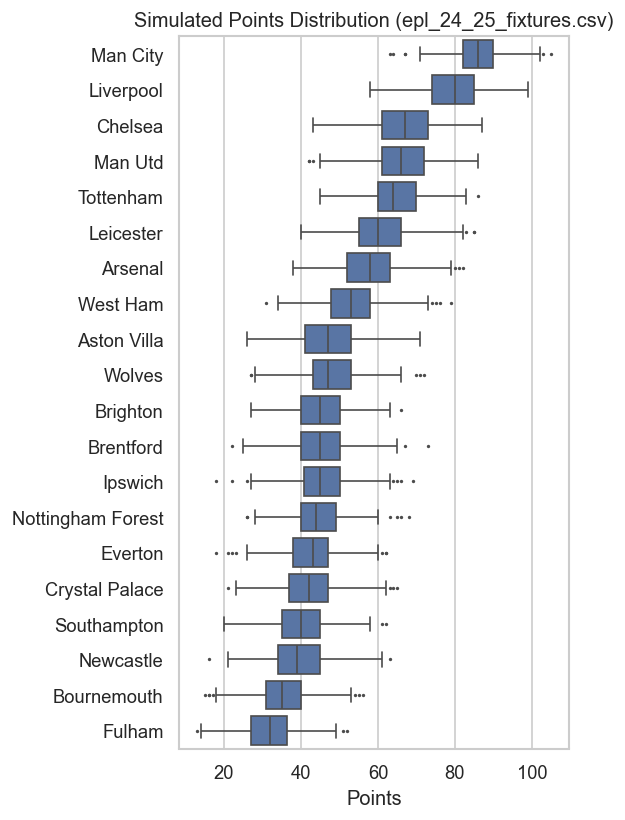

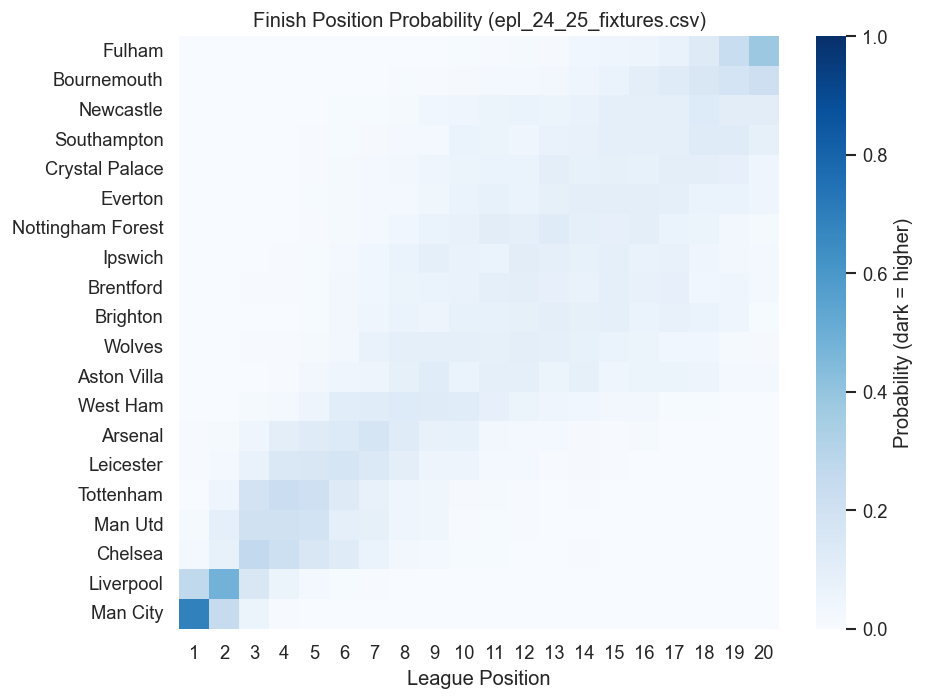

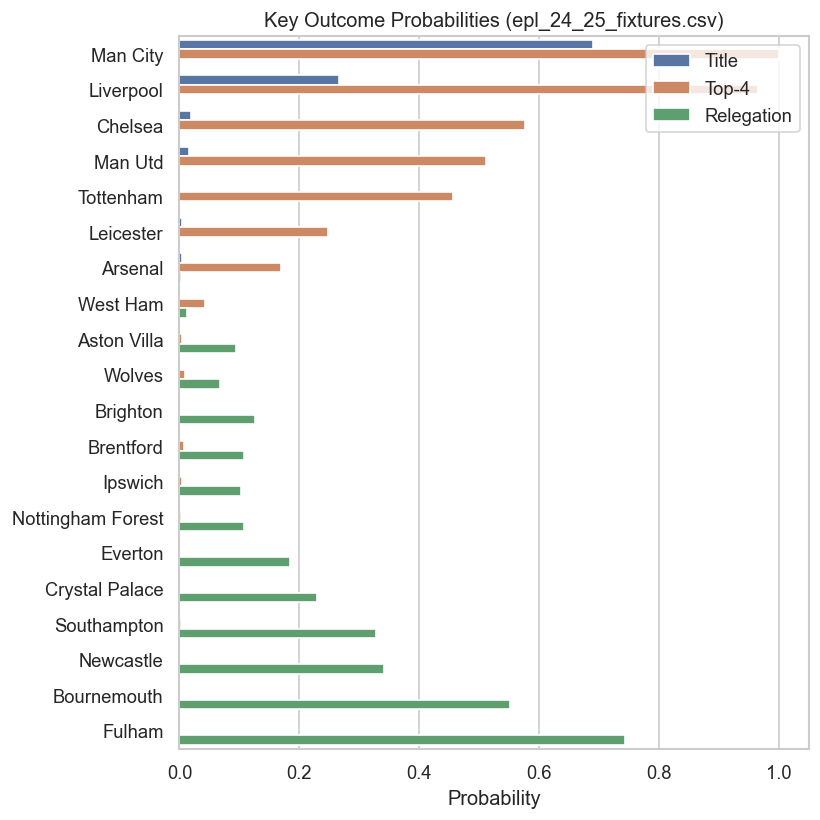


=== Predictions for epl_25_26_fixtures.csv ===
             Team  PredictedPts
         Man City          87.0
        Liverpool          80.0
          Chelsea          68.0
          Man Utd          68.0
        Tottenham          64.0
          Arsenal          59.0
         West Ham          54.0
           Wolves          49.0
      Aston Villa          48.0
        Brentford          46.0
         Brighton          46.0
       Sunderland          45.0
Nottingham Forest          44.5
          Everton          43.0
   Crystal Palace          43.0
            Leeds          43.0
          Burnley          41.0
        Newcastle          40.0
      Bournemouth          36.0
           Fulham          33.0


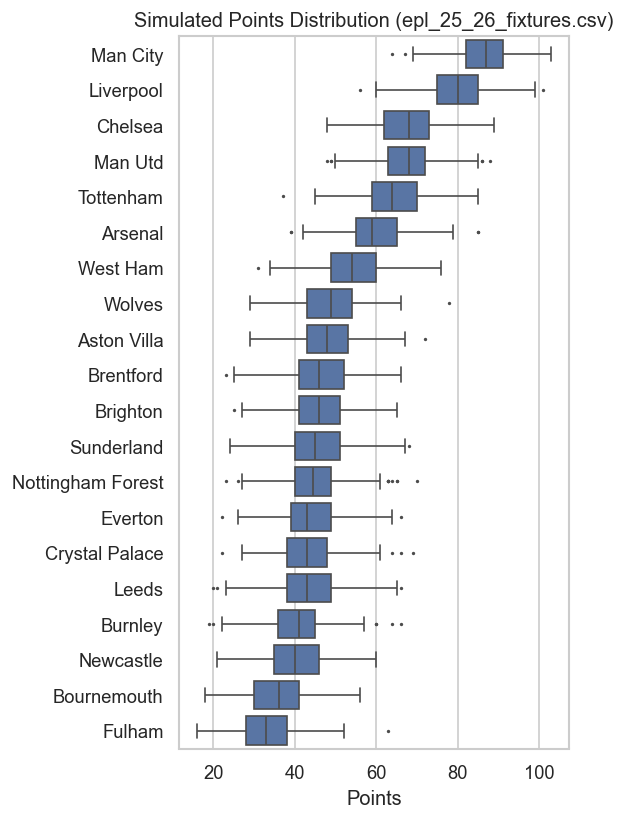

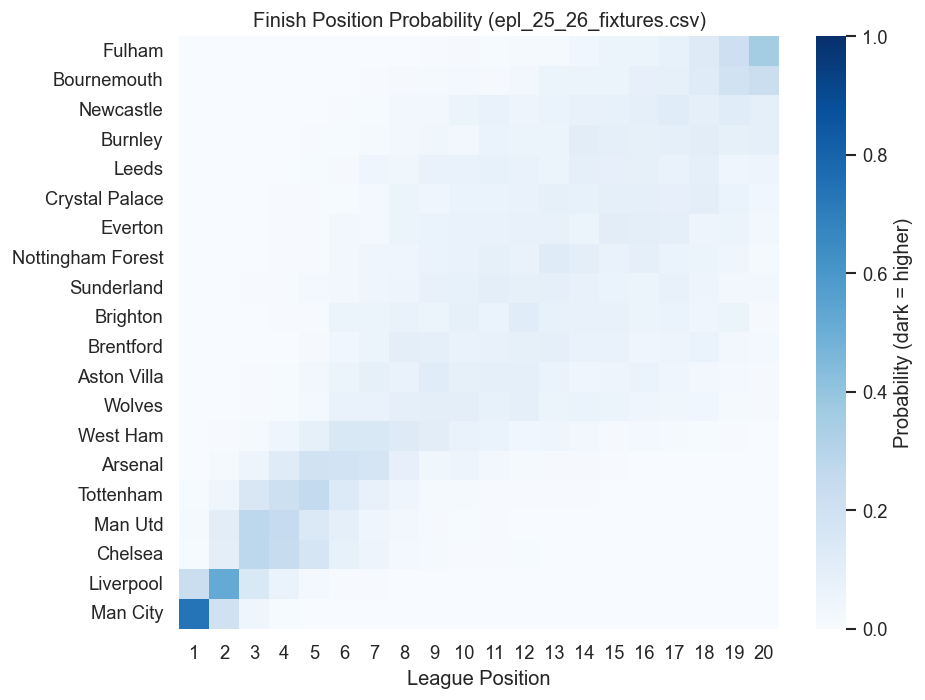

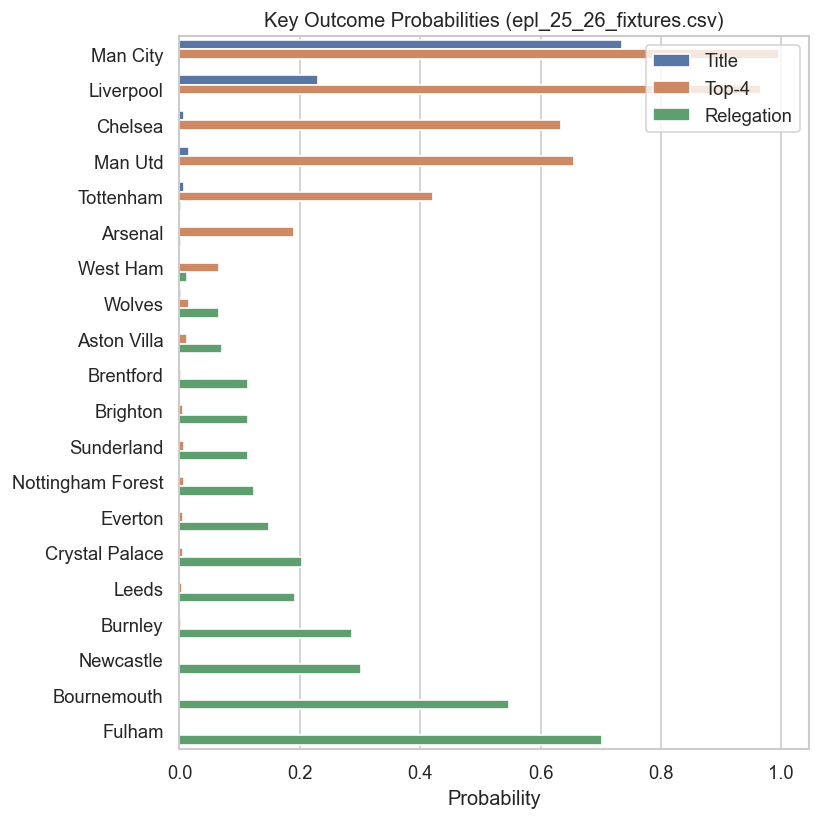

In [7]:

# 6) Main: train, tune, fit, simulate future
def main():
    # 6.1 Build training set
    train_list = [load_and_engineer_data(p) for p in training_csvs]
    train_df   = pd.concat(train_list, ignore_index=True)

    # Ensure every club in any fixture is included
    all_fixtures = pd.concat(
        [pd.read_csv(f)[["HomeTeam", "AwayTeam"]] for f in (backtest_fixtures_csvs + future_fixtures_csvs)],
        ignore_index=True
    )
    teams_all = sorted(set(get_unique_teams(train_df)) |
                       set(all_fixtures["HomeTeam"]) |
                       set(all_fixtures["AwayTeam"]))

    # 6.2 Tune via backtests (single grid for speed)
    best = search_params(train_df, backtest_fixtures_csvs, backtest_actual_pts_csvs, teams_all)
    best_K, best_gamma, best_lambda = best["K"], best["gamma"], best["lambda"]
    print(f"Tuned: K={best_K:.1f}, Gamma={best_gamma:.2f}, Lambda={best_lambda:.3f} (MAE={best['MAE']:.2f})")

    # 6.3 Fit final model
    df_e, elo_vec = compute_elo(train_df, teams_all, K=best_K, decay=0.995)
    fit_res = fit_bipois(df_e, teams_all, gamma=best_gamma, lambda_ridge=best_lambda)

   # 6.4 Simulate each future season + plots
    for csv in future_fixtures_csvs:
        csv = Path(csv)                    # ensure Path object
        label = csv.name     # taking just name of the file like "epl_25_26_fixtures.csv" as label
        

        fx = pd.read_csv(csv)[["HomeTeam", "AwayTeam"]]
        sim_mat = monte_carlo(fx, fit_res["par"], fit_res["idx"], elo_vec, best_gamma, n=N_SIMS)
        med_pts = sim_mat.median(axis=1)
        curr20  = pd.unique(pd.concat([fx["HomeTeam"], fx["AwayTeam"]]))
        out = (
        pd.DataFrame({"Team": med_pts.index, "PredictedPts": med_pts.values})
        .query("Team in @curr20")
        .sort_values("PredictedPts", ascending=False)
        .reset_index(drop=True)
        )

        print(f"\n=== Predictions for {label} ===")
        print(out.to_string(index=False))

        team_order = out["Team"].tolist()
        plot_points_boxplot(sim_mat, team_order, title=f"Simulated Points Distribution ({label})")
        prob_df, rank_long = compute_finish_probs(sim_mat, team_order)
        plot_finish_heatmap(rank_long, title=f"Finish Position Probability ({label})")
        plot_outcome_bars(prob_df, team_order, title=f"Key Outcome Probabilities ({label})")
if __name__ == "__main__":
    main()